In [1]:
import pandas as pd
df = pd.read_csv('full_resample.csv')

/Users/brianschor/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/brianschor/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

Decided to do additional modelling with boosting for the hitting stats.  This will be done with gridsearch

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import AdaBoostClassifier

Dropping the columns made without resampling

In [4]:
df.drop(columns=['traditional predictions', 'sabr_predictions'], inplace=True)

In [5]:
no_fun = ['H', 'RBI', 'HR', 'SO', 'AVG', 'OBP', 'OPS']
sabr = ['R', 'BB', 'IBB', 'OPS+', 'wRC+', 'WAR', 'TTO%']

In [6]:
df[no_fun].head()

,H,RBI,HR,SO,AVG,OBP,OPS
0,143,111,42,109,0.285,0.357,0.943
1,188,80,21,81,0.303,0.336,0.806
2,177,120,32,109,0.301,0.379,0.908
3,127,68,26,102,0.251,0.340,0.807
4,147,55,12,97,0.263,0.342,0.739


In [7]:
df[sabr].head()

,R,BB,IBB,OPS+,wRC+,WAR,TTO%
0,110,56,2,120,136,4.7,0.362
1,88,34,8,90,98,2.4,0.206
2,88,74,10,115,129,7.3,0.320
3,75,61,1,98,109,1.6,0.325
4,102,63,0,78,94,2.3,0.272


In [8]:
params = {
    'penalty': ['l1', 'l2'],
    'C': [1, 2,3,4,5,6,7,8,9,10]
}

In [9]:
grid = GridSearchCV(LogisticRegression(), param_grid=params)

In [10]:
X_t = df[no_fun]
X_s = df[sabr]
y = df['MVP']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y, stratify = y)

In [12]:
grid.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [13]:
a = grid.best_params_

In [14]:
ada_t = AdaBoostClassifier(base_estimator=LogisticRegression(C=a['C'], penalty=a['penalty']))

In [15]:
ada_t.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=LogisticRegression(C=6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [16]:
preds = ada_t.predict(df[no_fun])

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score

In [20]:
def metric_maker(y1, y2):
    
    '''Prints out a bunch of metrics and generates a confusion matrix'''
    
    print(f' Accuracy is {accuracy_score(y1, y2)}')
    
    print(f' Recall is {recall_score(y1,y2)}')
    
    print(f' Specificity is {recall_score(y1, y2, pos_label=0)}')

    return confusion_matrix(y1, y2)

In [21]:
metric_maker(y, preds)

 Accuracy is 0.9283333333333333
 Recall is 0.4666666666666667
 Specificity is 0.9796296296296296


array([[2645,   55],
       [ 160,  140]])

In [26]:
roc_auc_score(y, preds)

0.7231481481481482

In [25]:
scores = [recall_score(y, preds), 1-recall_score(y,preds)]

fpr, tpr, threshold = roc_curve(y, preds, pos_label=1)

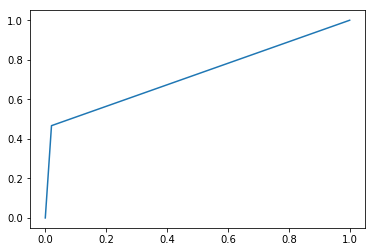

In [30]:
plt.plot(fpr, tpr);

Because all of my outcomes are 1 or 0, an auc/roc curve is not wholly appropriate for this.  

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, stratify = y)

In [47]:
grid.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [48]:
a = grid.best_params_

In [49]:
ada_s = AdaBoostClassifier(LogisticRegression(C=a['C'], penalty = a['penalty']))

In [50]:
ada_s.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [51]:
preds2= ada_s.predict(df[sabr])

In [52]:
metric_maker(y, preds2)

 Accuracy is 0.9266666666666666
 Recall is 0.47333333333333333
 Specificity is 0.977037037037037


array([[2638,   62],
       [ 158,  142]])